In [1]:
import functools
import os

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate, stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [6]:
redshift_sim = h5py.File(
    lib.const.REDSHIFT_CATALOGS[shear_step],
)

In [7]:
shear_sim = h5py.File(
    lib.const.IMSIM_CATALOGS[shear_step],
)

In [8]:
truth_match = h5py.File(
    lib.const.MATCH_CATALOGS[shear_step],
)

In [9]:
_, shear_sim_index, redshift_sim_index = np.intersect1d(
    shear_sim["mdet/noshear"]["uid"][:],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [10]:
np.testing.assert_equal(
    shear_sim["mdet/noshear"]["uid"][:][shear_sim_index],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:][redshift_sim_index],
)

In [11]:
bhat_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["bhat"][:][redshift_sim_index]

In [12]:
cell_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
cell_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["cell_wide"][:][redshift_sim_index]

In [13]:
weights_sim = lib.weights.get_shear_weights(shear_sim["mdet/noshear"])

In [14]:
response_sim = lib.response.get_shear_response(shear_sim["mdet/noshear"])

In [15]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        cell_sim[bhat_sim == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

In [16]:
_Z = truth_match["mdet/noshear"]["z"][:]

---

In [17]:
from boyan import Tz, rebin

In [18]:
z0 = 0.01

In [19]:
dz_005 = 0.05
zbinsc_005 = np.arange(z0 + dz_005 / 2, 6, dz_005)
zbins_005 = zbinsc_005 - dz_005 / 2
zbinsc_005 = np.append(
    [0],
    zbinsc_005,
)
zbins_005 = np.append(
    [0],
    zbins_005,
)
zbins_005 = np.append(
    zbins_005,
    zbins_005[-1] + dz_005,
)

In [20]:
# assert these are the same as what we've been working with up until now
np.testing.assert_allclose(zbinsc_005[:len(lib.const.ZVALS)], lib.const.ZVALS)
np.testing.assert_allclose(zbins_005[:len(lib.const.ZEDGES)], lib.const.ZEDGES)

In [21]:
dz_001 = 0.01

zbinsc_001 = np.arange(z0 + dz_001 / 2, 6, dz_001)
zbins_001 = zbinsc_001 - dz_001 / 2
zbinsc_001 = np.append(
    [0],
    zbinsc_001,
)
zbins_001 = np.append(
    [0],
    zbins_001,
)
zbins_001 = np.append(
    zbins_001,
    zbins_001[-1] + dz_001,
)

In [22]:
t_005 = Tz(dz_005, len(zbinsc_005) - 1, z0=z0 + dz_005 / 2)

In [23]:
t_001 = Tz(dz_001, len(zbinsc_001) - 1, z0=z0 + dz_001 / 2)

In [24]:
def _rebin(nz, from_binsc, to_binsc):
    # skip the first value because the zero-pad messes up the interpolation
    interp_func = interpolate.interp1d(from_binsc[1:], nz[1:], kind='linear', axis=0, bounds_error=False, fill_value=0)
    redshift_integrated = interp_func(to_binsc[1:])

    return redshift_integrated

In [25]:
# def rebin_001_to_005(nz):
#     redshift_original = np.append(nz, np.array([0, 0]))
#     zbinsc_laigle = np.arange(0, 3.02, 0.01)
#     zbinsc_integrate = np.arange(0.015, 3.015, 0.01)

#     interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
#     values = interp_func(zbinsc_integrate)


#     values = values.reshape((60, 5))
#     redshift_integrated = np.sum(values, axis=1)
    
#     return redshift_integrated

rebin_001_to_005 = functools.partial(
    _rebin,
    from_binsc=zbinsc_001,
    to_binsc=zbinsc_005,
)

In [26]:
# def rebin_005_to_001(nz):
#     zbinsc_laigle = np.arange(0, 3.02, 0.01)
#     zbinsc_integrate = np.arange(0.015, 3.015, 0.01)

#     interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
#     values = interp_func(zbinsc_integrate)


#     values = values.reshape((60, 5))
#     redshift_integrated = np.sum(values, axis=1)
    
#     return redshift_integrated

rebin_005_to_001 = functools.partial(
    _rebin,
    from_binsc=zbinsc_005,
    to_binsc=zbinsc_001,
)

---

In [27]:
nz_direct_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    # _zedges_005 = np.copy(zedges_005)
    # _zedges_005[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, zbins_005, weights=response_weight)[0]

    # Pileup at z=3
    # idx = np.min(np.where(zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz[idx + 1:] = 0

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_005[tomographic_bin] = nz / np.sum(nz) / np.diff(zbins_005)
    

In [28]:
nz_rebin_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_001, weights=response_weight, density=True)[0]
    # nz = np.append([0], nz)

    # Pileup at z=3
    # idx = np.min(np.where(zbins_001 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz[idx + 1:] = 0

    #Convert to Tz and dz=0.05
    y = rebin_001_to_005(nz)
    dndz_true = t_005.dndz(y, zbinsc_005)
    # dndz_true[0] = 0
    
    nz_rebin_005[tomographic_bin] = dndz_true
    

In [29]:
print("ks test")
print(
    f"bin"
    f"\tp-value (direct, rebin)"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    ks = stats.kstest(
        nz_direct_005[i],
        nz_rebin_005[i],
    )
    print(
        f"{i}\t{ks.pvalue :.4f}"
    )

ks test
bin	p-value (direct, rebin)
0	0.8933
1	0.7016
2	0.3941
3	0.5933


In [30]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc_005, weights=nz_direct_005[i]) :.4f}"
        "\t"
        f"\t{np.average(zbinsc_005, weights=nz_rebin_005[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3581		0.3529
1	0.5159		0.5085
2	0.7904		0.8032
3	1.0774		1.0777


In [31]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc_005, weights=nz_rebin_005[i]) - np.average(zbinsc_005, weights=nz_direct_005[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	-0.0052
1	-0.0074
2	0.0128
3	0.0003


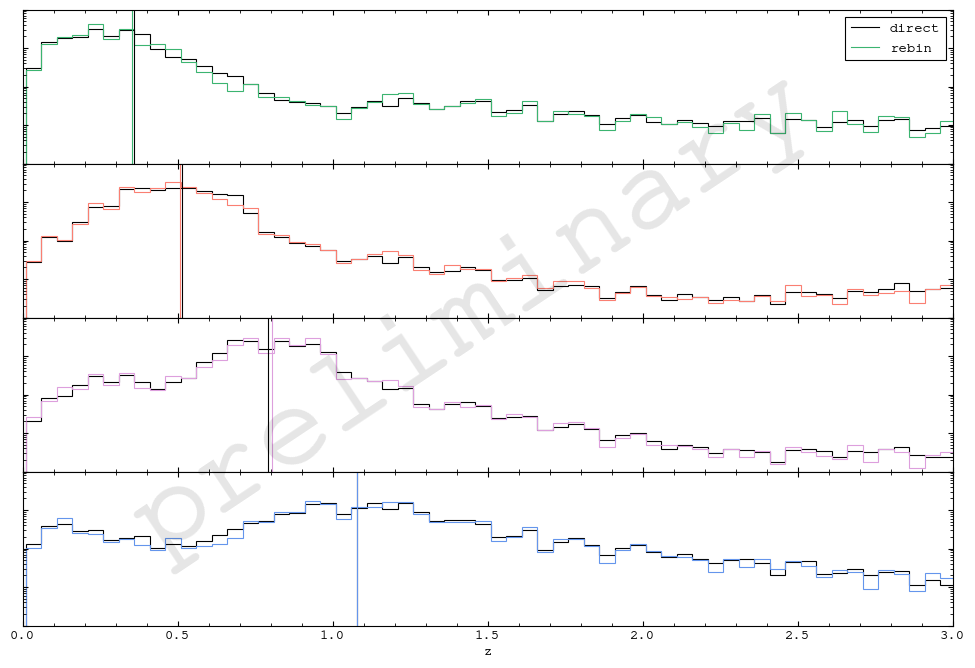

In [32]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc_005, weights=nz_direct_005[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_005[i],
        edges=zbins_005,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zbinsc_005, weights=nz_rebin_005[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_005[i],
        edges=zbins_005,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")
axs[-1].set_ylim(1e-3, 1e1)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

---

In [33]:
nz_direct_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    # _zedges_001 = np.copy(zedges_001)
    # _zedges_001[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, zbins_001, weights=response_weight)[0]

    # Pileup at z=3
    # idx = np.min(np.where(zbins_001 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz[idx + 1:] = 0

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_001[tomographic_bin] = nz / np.sum(nz) / np.diff(zbins_001)
    

In [34]:
nz_rebin_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_005, weights=response_weight, density=True)[0]
    # nz = np.append([0], nz)

    # Pileup at z=3
    # idx = np.min(np.where(zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz[idx + 1:] = 0

    #Convert to Tz and dz=0.01
    y = rebin_005_to_001(nz)
    dndz_true = t_001.dndz(y, zbinsc_001)
    # dndz_true[0] = 0
    
    nz_rebin_001[tomographic_bin] = dndz_true
    

In [35]:
print("ks test")
print(
    f"bin"
    f"\tp-value (direct, rebin)"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    ks = stats.kstest(
        nz_direct_001[i],
        nz_rebin_001[i],
    )
    print(
        f"{i}\t{ks.pvalue :.4f}"
    )

ks test
bin	p-value (direct, rebin)
0	0.0006
1	0.0003
2	0.0002
3	0.0000


In [36]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc_001, weights=nz_direct_001[i]) :.4f}"
        "\t"
        f"\t{np.average(zbinsc_001, weights=nz_rebin_001[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3571		0.3602
1	0.5156		0.5162
2	0.7905		0.7908
3	1.0773		1.0803


In [37]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc_001, weights=nz_rebin_001[i]) - np.average(zbinsc_001, weights=nz_direct_001[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	0.0031
1	0.0006
2	0.0003
3	0.0030


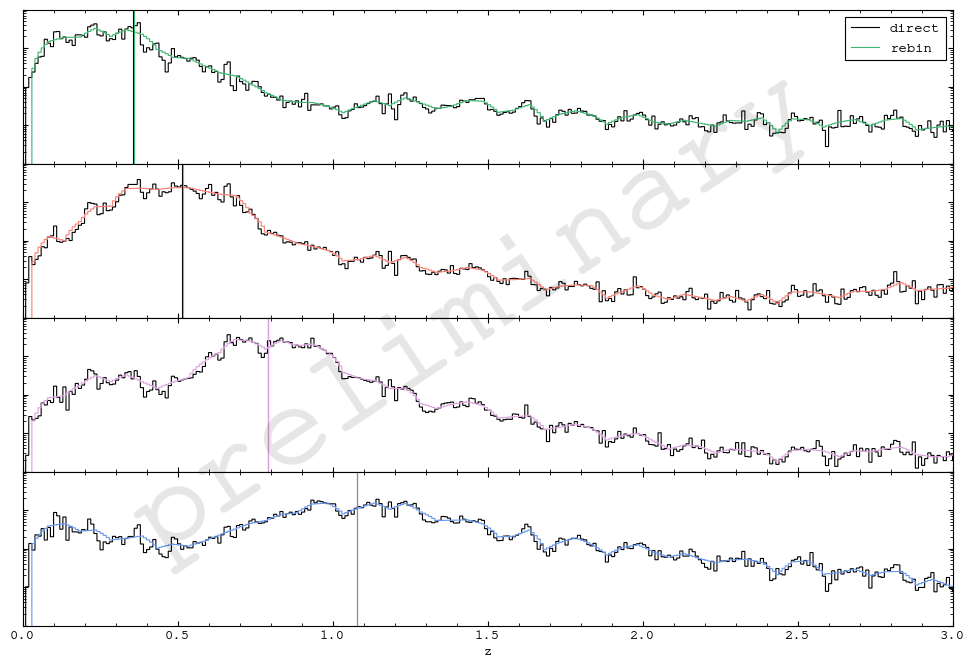

In [38]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc_001, weights=nz_direct_001[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_001[i],
        edges=zbins_001,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zbinsc_001, weights=nz_rebin_001[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_001[i],
        edges=zbins_001,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")
axs[-1].set_ylim(1e-3, 1e1)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()